In [28]:
# Imports
import os
import requests
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Load .env environment variables
load_dotenv()

True

In [30]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [31]:
from alpaca_trade_api.rest import REST, TimeFrame

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
df = alpaca.get_bars("AMZN", TimeFrame.Minute, "2020-10-08", "2021-10-29", adjustment='raw').df
df.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-10-08 10:45:00+00:00,3211.95,3211.95,3211.95,3211.95,216,7,3211.780787
2020-10-08 11:01:00+00:00,3208.31,3208.31,3207.12,3207.12,942,49,3208.123068
2020-10-08 11:06:00+00:00,3208.27,3208.27,3208.27,3208.27,177,13,3208.574463
2020-10-08 11:07:00+00:00,3209.67,3209.67,3209.67,3209.67,488,33,3210.255963
2020-10-08 11:09:00+00:00,3212.00,3212.00,3212.00,3212.00,1524,28,3212.028904


In [32]:
# Drop irrelevant columns from dataframe

df.drop(columns=["open", "high", "low", "volume", "trade_count", "vwap"], inplace=True)
df.head()

,close
timestamp,
2020-10-08 10:45:00+00:00,3211.95
2020-10-08 11:01:00+00:00,3207.12
2020-10-08 11:06:00+00:00,3208.27
2020-10-08 11:07:00+00:00,3209.67
2020-10-08 11:09:00+00:00,3212.00


In [33]:
# Calculate sma, standard deviation, and bollinger bands; assign buy and sell signals. When lower band is greater than the price, execute buy; when upper band is less than price execute sell.

df['SMA'] = df.close.rolling(window=20).mean()
df['stddev'] = df.close.rolling(window=20).std()
df['Upper'] = df.SMA +2* df.stddev
df['Lower'] = df.SMA -2* df.stddev

df['Buy_Signal'] = np.where(df.Lower > df.close, True, False)
df['Sell_Signal'] = np.where(df.Upper < df.close, True, False)

# Drop nulls

df.dropna(inplace=True)
df.head()

,close,SMA,stddev,Upper,Lower,Buy_Signal,Sell_Signal
timestamp,,,,,,,
2020-10-08 11:46:00+00:00,3217.99,3215.1850,3.615622,3222.416244,3207.953756,False,False
2020-10-08 11:48:00+00:00,3217.00,3215.4375,3.553616,3222.544732,3208.330268,False,False
2020-10-08 11:49:00+00:00,3215.50,3215.8565,2.966900,3221.790301,3209.922699,False,False
2020-10-08 11:56:00+00:00,3216.00,3216.2430,2.370048,3220.983096,3211.502904,False,False
2020-10-08 12:00:00+00:00,3218.98,3216.7085,1.873337,3220.455174,3212.961826,False,False


In [34]:
# Trading Loop

buys = []
sells = []
open_pos = False 

for i in range(19,len(df)):
    if df.Lower[i] > df.close[i]:
        if open_pos == False: 
            buys.append(i)
            open_pos = True 
    elif df.Upper[i] < df.close[i]:
        if open_pos:
            sells.append(i)
            open_pos = False

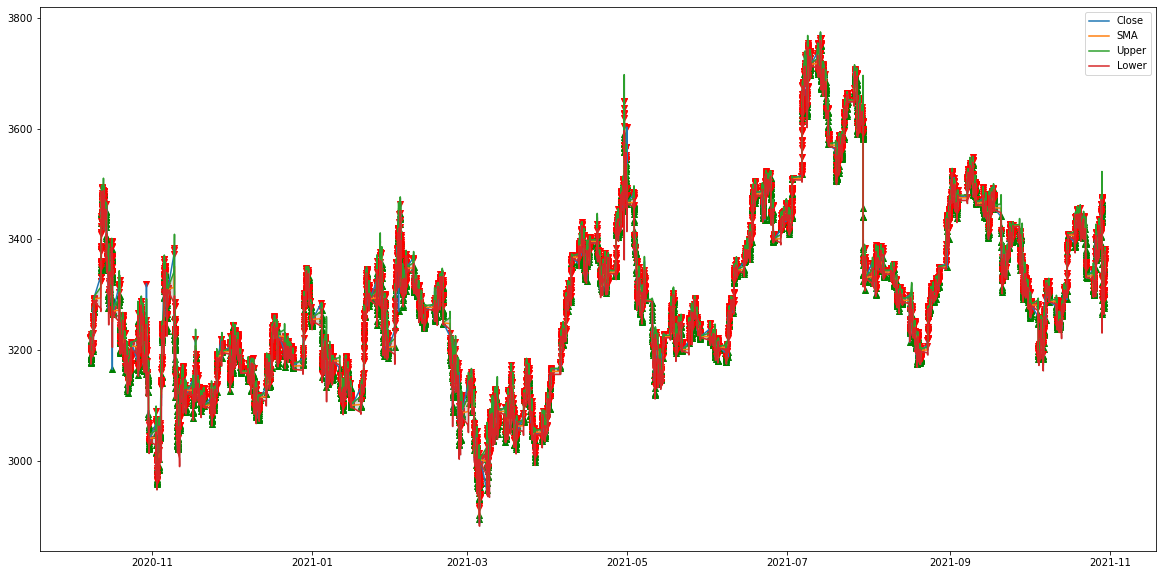

In [35]:
# Plot Bollinger bands with Buy/Sell indicators

plt.figure(figsize=(20,10))
plt.plot(df[['close', 'SMA', 'Upper', 'Lower']])
plt.scatter(df.index[df.Buy_Signal], df[df.Buy_Signal].close, marker = '^', color='g')
plt.scatter(df.index[df.Sell_Signal], df[df.Sell_Signal].close, marker = 'v', color = 'r')
plt.fill_between(df.index, df.Upper, df.Lower, color='grey', alpha=0.3)
plt.legend(['Close', 'SMA', 'Upper', 'Lower'])
plt.show()

In [36]:
# Create merged df to view trades in chronological order

merged = pd.concat([df.iloc[buys].close, df.iloc[sells].close], axis=1)
merged.columns = ['Buys','Sells']
merged.head()

,Buys,Sells
timestamp,,
2020-10-08 13:33:00+00:00,3218.25,NaN
2020-10-08 15:05:00+00:00,NaN,3196.575
2020-10-08 15:33:00+00:00,3186.00,NaN
2020-10-08 16:05:00+00:00,NaN,3195.130
2020-10-08 17:24:00+00:00,3191.40,NaN


In [37]:
# Calculate profit by calculating the difference between buy and sell orders. 
# Calculate relative profit by dividing profit per trade by the previous buy price. 

totalprofit = merged.shift(-1).Sells - merged.Buys
relprofits = (merged.shift(-1).Sells - merged.Buys)/merged.Buys

# View sum of total profit
totalprofit.sum()

2513.377899999983

In [46]:
# View sum of relative profits
relprofits.sum()

0.8009120162571187

In [44]:
# Create dataframe to visualize buy price, sell price, cumulative returns, account balance Starting with 100,000, and fees per trade. 

merged['pct_change'] = (merged.shift(-1).Sells - merged.Buys)/merged.Buys
merged['cum_returns'] = (1 + merged['pct_change']).cumprod()
merged['balance'] = 100000 * merged['cum_returns']
merged['buy_fees'] = merged['Buys'] * .01 
merged['sell_fees'] = merged['Sells'] * .01 
merged.head()

,Buys,Sells,pct_change,cum_returns,balance,buy_fees,sell_fees
timestamp,,,,,,,
2020-10-08 13:33:00+00:00,3218.25,NaN,-0.006735,0.993265,99326.497320,32.1825,NaN
2020-10-08 15:05:00+00:00,NaN,3196.575,NaN,NaN,NaN,NaN,31.96575
2020-10-08 15:33:00+00:00,3186.00,NaN,0.002866,0.996111,99611.133516,31.8600,NaN
2020-10-08 16:05:00+00:00,NaN,3195.130,NaN,NaN,NaN,NaN,31.95130
2020-10-08 17:24:00+00:00,3191.40,NaN,0.000876,0.996984,99698.372069,31.9140,NaN


In [40]:
# Display Ending Balance

EB = merged.balance[2734]
fees = merged.buy_fees.sum() + merged.sell_fees.sum()
adj_EB = EB - fees
adj_EB

128018.47361515908

In [57]:
## Repeat process for AMD

In [58]:
df2 = alpaca.get_bars("AMD", TimeFrame.Minute, "2020-10-08", "2021-10-29", adjustment='raw').df
df2.drop(columns=["open", "high", "low", "volume", "trade_count", "vwap"], inplace=True)

In [59]:
df2['SMA'] = df2.close.rolling(window=20).mean()
df2['stddev'] = df2.close.rolling(window=20).std()
df2['Upper'] = df2.SMA +2* df2.stddev
df2['Lower'] = df2.SMA -2* df2.stddev

df2['Buy_Signal'] = np.where(df2.Lower > df2.close, True, False)
df2['Sell_Signal'] = np.where(df2.Upper < df2.close, True, False)

df2.dropna(inplace=True)
df2

,close,SMA,stddev,Upper,Lower,Buy_Signal,Sell_Signal
timestamp,,,,,,,
2020-10-08 09:04:00+00:00,87.68,87.4765,0.076590,87.629680,87.323320,False,True
2020-10-08 09:05:00+00:00,87.63,87.4815,0.083242,87.647984,87.315016,False,False
2020-10-08 09:08:00+00:00,87.65,87.4890,0.091358,87.671716,87.306284,False,False
2020-10-08 09:10:00+00:00,87.65,87.4965,0.098209,87.692918,87.300082,False,False
2020-10-08 09:11:00+00:00,87.65,87.5045,0.103998,87.712495,87.296505,False,False
...,...,...,...,...,...,...,...
2021-10-29 23:55:00+00:00,120.25,120.2655,0.024165,120.313830,120.217170,False,False
2021-10-29 23:56:00+00:00,120.27,120.2660,0.024149,120.314297,120.217703,False,False
2021-10-29 23:57:00+00:00,120.26,120.2660,0.024149,120.314297,120.217703,False,False


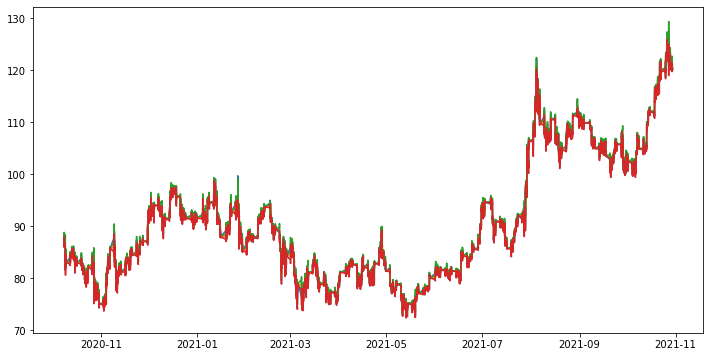

In [60]:
plt.figure(figsize=(12,6))
plt.plot(df2[['close', 'SMA', 'Upper', 'Lower']])
plt.fill_between(df2.index, df2.Upper, df2.Lower, color='grey', alpha=0.3)
plt.show()

In [61]:
buys = []
sells = []
open_pos = False 

for i in range(20,len(df2)):
    if df2.Lower[i] > df2.close[i]:
        if open_pos == False: 
            buys.append(i)
            open_pos = True 
    elif df2.Upper[i] < df2.close[i]:
        if open_pos:
            sells.append(i)
            open_pos = False

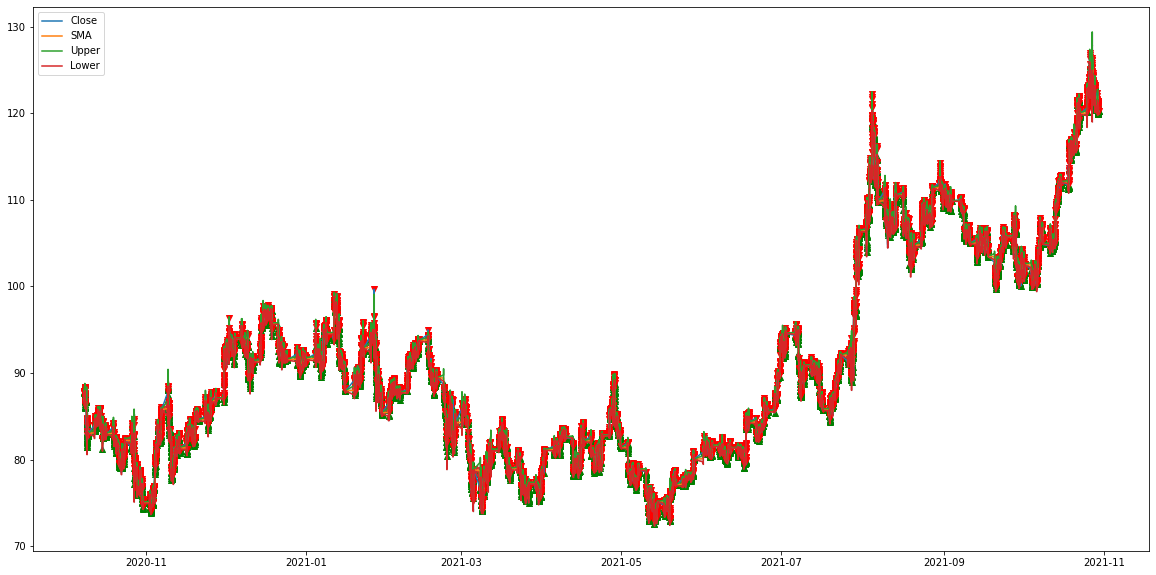

In [62]:
plt.figure(figsize=(20,10))
plt.plot(df2[['close', 'SMA', 'Upper', 'Lower']])
plt.scatter(df2.index[df2.Buy_Signal], df2[df2.Buy_Signal].close, marker = '^', color='g')
plt.scatter(df2.index[df2.Sell_Signal], df2[df2.Sell_Signal].close, marker = 'v', color = 'r')
plt.fill_between(df2.index, df2.Upper, df2.Lower, color='grey', alpha=0.3)
plt.legend(['Close', 'SMA', 'Upper', 'Lower'])
plt.show()

In [63]:
merged2 = pd.concat([df2.iloc[buys].close, df2.iloc[sells].close], axis=1)
merged2.columns = ['Buys','Sells']
merged2

,Buys,Sells
timestamp,,
2020-10-08 11:09:00+00:00,87.6800,NaN
2020-10-08 11:46:00+00:00,NaN,87.87
2020-10-08 12:20:00+00:00,87.8700,NaN
2020-10-08 12:57:00+00:00,NaN,87.95
2020-10-08 13:16:00+00:00,87.9100,NaN
...,...,...
2021-10-29 18:32:00+00:00,121.0877,NaN
2021-10-29 20:33:00+00:00,NaN,120.25
2021-10-29 20:47:00+00:00,120.1501,NaN


In [64]:
merged2['pct_change'] = (merged2.shift(-1).Sells - merged2.Buys)/merged2.Buys
merged2['cum_returns'] = (1 + merged2['pct_change']).cumprod()
merged2['balance'] = 100000 * merged2['cum_returns']
merged2['buy_fees'] = merged2['Buys'] * .01 
merged2['sell_fees'] = merged2['Sells'] * .01 
merged2

,Buys,Sells,pct_change,cum_returns,balance,buy_fees,sell_fees
timestamp,,,,,,,
2020-10-08 11:09:00+00:00,87.6800,NaN,0.002167,1.002167,100216.697080,0.876800,NaN
2020-10-08 11:46:00+00:00,NaN,87.87,NaN,NaN,NaN,NaN,0.8787
2020-10-08 12:20:00+00:00,87.8700,NaN,0.000910,1.003079,100307.937956,0.878700,NaN
2020-10-08 12:57:00+00:00,NaN,87.95,NaN,NaN,NaN,NaN,0.8795
2020-10-08 13:16:00+00:00,87.9100,NaN,0.001024,1.004106,100410.630647,0.879100,NaN
...,...,...,...,...,...,...,...
2021-10-29 18:32:00+00:00,121.0877,NaN,-0.006918,2.369326,236932.553674,1.210877,NaN
2021-10-29 20:33:00+00:00,NaN,120.25,NaN,NaN,NaN,NaN,1.2025
2021-10-29 20:47:00+00:00,120.1501,NaN,0.000831,2.371296,237129.553611,1.201501,NaN


In [65]:
EB2 = merged2.balance[2664]
fees2 = merged2.buy_fees.sum() + merged2.sell_fees.sum()
adj_EB2 = EB2 - fees2
adj_EB2

171865.6557068344

In [66]:
totalprofit2 = merged2.shift(-1).Sells - merged2.Buys
relprofits2 = (merged2.shift(-1).Sells - merged2.Buys)/merged2.Buys
totalprofit2.sum()

77.35599600000023

In [67]:
relprofits2.sum()

0.904584448356004

In [68]:
# Repeat Process for SPY

In [71]:
df3 = alpaca.get_bars("SPY", TimeFrame.Minute, "2020-10-08", "2021-10-29", adjustment='raw').df
df3.drop(columns=["open", "high", "low", "volume", "trade_count", "vwap"], inplace=True)

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SPY/bars 3 more time(s)...


In [72]:
df3['SMA'] = df3.close.rolling(window=20).mean()
df3['stddev'] = df3.close.rolling(window=20).std()
df3['Upper'] = df3.SMA +2* df3.stddev
df3['Lower'] = df3.SMA -2* df3.stddev

df3['Buy_Signal'] = np.where(df3.Lower > df3.close, True, False)
df3['Sell_Signal'] = np.where(df3.Upper < df3.close, True, False)

df3.dropna(inplace=True)
df3

,close,SMA,stddev,Upper,Lower,Buy_Signal,Sell_Signal
timestamp,,,,,,,
2020-10-08 08:23:00+00:00,342.03,342.2680,0.173800,342.615599,341.920401,False,False
2020-10-08 08:24:00+00:00,342.01,342.2410,0.169578,342.580157,341.901843,False,False
2020-10-08 08:25:00+00:00,342.00,342.2190,0.170939,342.560877,341.877123,False,False
2020-10-08 08:26:00+00:00,341.73,342.1790,0.187164,342.553329,341.804671,True,False
2020-10-08 08:27:00+00:00,341.60,342.1365,0.216583,342.569666,341.703334,True,False
...,...,...,...,...,...,...,...
2021-10-29 23:55:00+00:00,459.65,459.6380,0.047195,459.732390,459.543610,False,False
2021-10-29 23:56:00+00:00,459.65,459.6400,0.046792,459.733584,459.546416,False,False
2021-10-29 23:57:00+00:00,459.67,459.6435,0.046257,459.736015,459.550985,False,False


In [73]:
buys = []
sells = []
open_pos = False 

for i in range(20,len(df3)):
    if df3.Lower[i] > df3.close[i]:
        if open_pos == False: 
            buys.append(i)
            open_pos = True 
    elif df3.Upper[i] < df3.close[i]:
        if open_pos:
            sells.append(i)
            open_pos = False

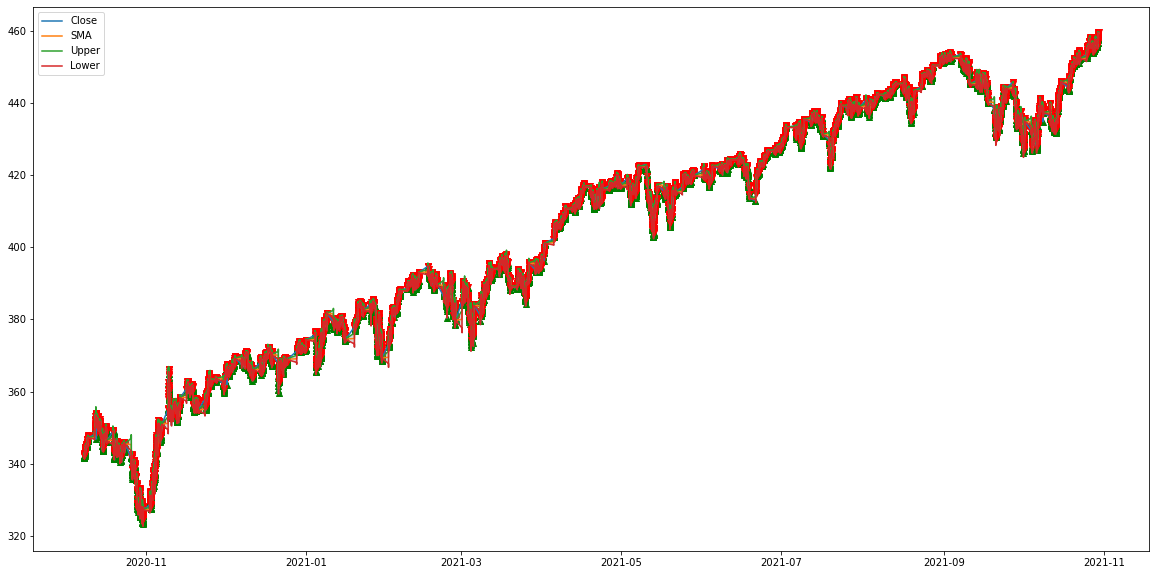

In [74]:
plt.figure(figsize=(20,10))
plt.plot(df3[['close', 'SMA', 'Upper', 'Lower']])
plt.scatter(df3.index[df3.Buy_Signal], df3[df3.Buy_Signal].close, marker = '^', color='g')
plt.scatter(df3.index[df3.Sell_Signal], df3[df3.Sell_Signal].close, marker = 'v', color = 'r')
plt.fill_between(df3.index, df3.Upper, df3.Lower, color='grey', alpha=0.3)
plt.legend(['Close', 'SMA', 'Upper', 'Lower'])
plt.show()

In [75]:
merged3 = pd.concat([df3.iloc[buys].close, df3.iloc[sells].close], axis=1)
merged3.columns = ['Buys','Sells']
merged3

,Buys,Sells
timestamp,,
2020-10-08 09:34:00+00:00,341.94,NaN
2020-10-08 10:06:00+00:00,NaN,342.170
2020-10-08 10:59:00+00:00,342.04,NaN
2020-10-08 12:07:00+00:00,NaN,342.330
2020-10-08 13:31:00+00:00,342.57,NaN
...,...,...
2021-10-29 17:15:00+00:00,NaN,458.990
2021-10-29 17:35:00+00:00,458.69,NaN
2021-10-29 18:42:00+00:00,NaN,458.210


In [76]:
merged3['pct_change'] = (merged3.shift(-1).Sells - merged3.Buys)/merged3.Buys
merged3['cum_returns'] = (1 + merged3['pct_change']).cumprod()
merged3['balance'] = 100000 * merged3['cum_returns']
merged3['buy_fees'] = merged3['Buys'] * .01 
merged3['sell_fees'] = merged3['Sells'] * .01 
merged3

,Buys,Sells,pct_change,cum_returns,balance,buy_fees,sell_fees
timestamp,,,,,,,
2020-10-08 09:34:00+00:00,341.94,NaN,0.000673,1.000673,100067.263263,3.4194,NaN
2020-10-08 10:06:00+00:00,NaN,342.170,NaN,NaN,NaN,NaN,3.42170
2020-10-08 10:59:00+00:00,342.04,NaN,0.000848,1.001521,100152.105697,3.4204,NaN
2020-10-08 12:07:00+00:00,NaN,342.330,NaN,NaN,NaN,NaN,3.42330
2020-10-08 13:31:00+00:00,342.57,NaN,0.001314,1.002837,100283.665517,3.4257,NaN
...,...,...,...,...,...,...,...
2021-10-29 17:15:00+00:00,NaN,458.990,NaN,NaN,NaN,NaN,4.58990
2021-10-29 17:35:00+00:00,458.69,NaN,-0.001046,1.395079,139507.940241,4.5869,NaN
2021-10-29 18:42:00+00:00,NaN,458.210,NaN,NaN,NaN,NaN,4.58210


In [77]:
EB3 = merged3.balance[2664]
fees3 = merged3.buy_fees.sum() + merged3.sell_fees.sum()
adj_EB3 = EB3 - fees3
adj_EB3

109205.66857542295

In [78]:
totalprofit3 = merged3.shift(-1).Sells - merged3.Buys
relprofits3 = (merged3.shift(-1).Sells - merged3.Buys)/merged3.Buys
totalprofit3.sum()

132.1315999999996

In [79]:
relprofits3.sum()

0.33961321830421376